In [125]:
import torch
from pykan.kan.spline import curve2coef, coef2curve, B_batch
from torch import nn

import numpy as np
from tqdm import tqdm

In [126]:
device='cuda'

In [127]:
class LAN_layer(nn.Module):
    def __init__(
        self,
        dim=2,
        num=5,
        k=3,
        noise_scale=0.1,
        scale_base=1.0,
        scale_sp=1.0,
        base_fun=torch.nn.SiLU(),
        grid_eps=0.02,
        grid_range=[-1,1],
        sp_trainable=True,
        sb_trainable=True,
        device='cpu'
    ):
        super().__init__()

        self.dim = dim
        self.num = num
        self.k = k 
        self.base_fun = base_fun
        self.device = device

        # определить grid
        self.grid = torch.einsum('i,j->ij', torch.ones(self.dim, device=device), torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device))
        self.grid = torch.nn.Parameter(self.grid).requires_grad_(False)

        noises = (torch.rand(self.dim, self.grid.shape[1]) - 1 / 2) * noise_scale / num
        noises = noises.to(device)
        # shape: (size, coef)
        self.coef = torch.nn.Parameter(curve2coef(self.grid, noises, self.grid, k, device))

    def forward(self, x):
        # (batch, dim) -> (dim, batch)
        x = x.permute(1, 0)
        y = coef2curve(x_eval=x, grid=self.grid, coef=self.coef, k=self.k, device=self.device).permute(1, 0)  # shape (batch, dim)
        return y
    
    # def update_grid_from_samples(self, x):
    #     batch = x.shape[0]
    #     x = torch.einsum('ij,k->ikj', x, torch.ones(self.dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
    #     x_pos = torch.sort(x, dim=1)[0]
    #     y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
    #     num_interval = self.grid.shape[1] - 1
    #     ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
    #     grid_adaptive = x_pos[:, ids]
    #     margin = 0.01
    #     grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
    #     self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
    #     self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)

In [128]:
torch.sum(torch.arange(18).reshape(6,3), dim=1)

tensor([ 3, 12, 21, 30, 39, 48])

In [129]:
functions = {
    'f(x) = J_0(20x)': (1, lambda x: torch.special.bessel_j0(20 * x)),
    'f(x, y) = \exp(\sin(\pi x) + y^2)': (2, lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)), 
    'f(x, y) = xy': (2, lambda x: x[:,[0]] * x[:,[1]]), 
    # 'f(x) = \exp(\frac{1}{100}(\sum_{i=1}^{100}\sin^2(\frac{\pi x}{2})))': (100, lambda x:  torch.exp(1/100 * torch.sum(torch.sin(torch.pi * x / 2), dim=1))),
    'f(x) = \exp(\sin(x^2_1 + x^2_2) + \sin(x^2_3 + x^2_4))': (4, lambda x: torch.exp(torch.sin(x[:,[0]]**2 + x[:,[1]]**2) + torch.sin(x[:,[3]]**2 + x[:,[4]]**2)))
}

In [130]:
from pykan.kan.utils import create_dataset

In [131]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [132]:
num = 7

In [133]:
from pykan.kan.KAN import KAN

# KAN

# 10
kan_1 = {
    1: KAN([1, 1], num, device=device).to(device),
    2: KAN([2, 1], num, device=device).to(device) ,
    100: KAN([100, 1], num, device=device).to(device),
    4: KAN([4, 1], num, device=device).to(device) 
}

kan_2 = {
    1: KAN([1, 4, 1], num, device=device).to(device),
    2: KAN([2, 4, 1], num, device=device).to(device) ,
    100: KAN([100, 4, 1], num, device=device).to(device),
    4: KAN([4, 4, 1], num, device=device).to(device) 
}

kan_3 = {
    1: KAN([1, 3, 5, 1], num, device=device).to(device),
    2: KAN([2, 3, 5, 1], num, device=device).to(device) ,
    100: KAN([100, 3, 5, 1], num, device=device).to(device),
    4: KAN([4, 3, 5, 1], num, device=device).to(device) 
}

kan_4 = {
    1: KAN([1, 3, 5, 7, 1], num, device=device).to(device),
    2: KAN([2, 3, 5, 7, 1], num, device=device).to(device) ,
    100: KAN([100, 3, 5, 7, 1], num, device=device).to(device),
    4: KAN([4, 3, 5, 7, 1], num, device=device).to(device) 
}

kans = [kan_1, kan_2, kan_3, kan_4]

In [134]:
def create_lan_1(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim, 3),
        nn.BatchNorm1d(3),
        LAN_layer(3, num=num, device=device),
        nn.Linear(3, 1),
    ).to(device)
    return model_lan

def create_lan_2(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim,4),
        nn.BatchNorm1d(4),
        LAN_layer(4, num=num, device=device),

        nn.Linear(4, 4),
        nn.BatchNorm1d(4),
        LAN_layer(4, num=num, device=device),

        nn.Linear(4, 1),
    ).to(device)
    return model_lan

def create_lan_3(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim,5),
        nn.BatchNorm1d(5),
        LAN_layer(5, num=num, device=device),

        nn.Linear(5, 7),
        nn.BatchNorm1d(7),
        LAN_layer(7, num=num, device=device),
         
        nn.Linear(7, 5),
        nn.BatchNorm1d(5),
        LAN_layer(5, num=num, device=device),
        
        nn.Linear(5, 1),
    ).to(device)
    return model_lan

def create_lan_4(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim,8),
        nn.BatchNorm1d(8),
        LAN_layer(8, num=num, device=device),

        nn.Linear(8, 16),
        nn.BatchNorm1d(16),
        LAN_layer(16, num=num, device=device),

         nn.Linear(16, 16),
        nn.BatchNorm1d(16),
        LAN_layer(16, num=num, device=device),
         
        nn.Linear(16, 4),
        nn.BatchNorm1d(4),
        LAN_layer(4, num=num, device=device),
        
        nn.Linear(4, 1),
    ).to(device)
    return model_lan

# lan

lans = [
    {x: create_lan_1(x) for x in [1, 2, 100, 4]},
    {x: create_lan_2(x) for x in [1, 2, 100, 4]},
    {x: create_lan_3(x) for x in [1, 2, 100, 4]},
    {x: create_lan_4(x) for x in [1, 2, 100, 4]}
]

In [135]:
def create_mlp_1(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim, 3),
        nn.BatchNorm1d(3),
        nn.ReLU(True),
        nn.Linear(3, 1),
    ).to(device)
    return model_lan

def create_mlp_2(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim,4),
        nn.BatchNorm1d(4),
        nn.ReLU(True),

        nn.Linear(4, 4),
        nn.BatchNorm1d(4),
        nn.ReLU(True),

        nn.Linear(4, 1),
    ).to(device)
    return model_lan

def create_mlp_3(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim,5),
        nn.BatchNorm1d(5),
        nn.ReLU(True),

        nn.Linear(5, 7),
        nn.BatchNorm1d(7),
        nn.ReLU(True),
         
        nn.Linear(7, 5),
        nn.BatchNorm1d(5),
        nn.ReLU(True),
        
        nn.Linear(5, 1),
    ).to(device)
    return model_lan

def create_mlp_4(in_dim):
    model_lan = nn.Sequential(
        nn.Linear(in_dim,8),
        nn.BatchNorm1d(8),
        nn.ReLU(True),

        nn.Linear(8, 16),
        nn.BatchNorm1d(16),
        nn.ReLU(True),

         nn.Linear(16, 16),
        nn.BatchNorm1d(16),
        nn.ReLU(True),
         
        nn.Linear(16, 4),
        nn.BatchNorm1d(4),
        nn.ReLU(True),
        
        nn.Linear(4, 1),
    ).to(device)
    return model_lan

# lan

mlps = [
    {x: create_mlp_1(x) for x in [1, 2, 100, 4]},
    {x: create_mlp_2(x) for x in [1, 2, 100, 4]},
    {x: create_mlp_3(x) for x in [1, 2, 100, 4]},
    {x: create_mlp_4(x) for x in [1, 2, 100, 4]}
]

In [136]:
from collections import defaultdict
import time
import numpy as np

batch_size = 128
batch_size_test = 128

steps = 2000

loss_fn = lambda x, y: torch.mean((x - y) ** 2)
loss_fn_eval = lambda x, y: torch.sqrt(torch.mean((x - y) ** 2))

def train(model, dataset):
    metrics = defaultdict(list)

    optimizer = torch.optim.AdamW(model.parameters())

    for _ in range(steps):
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)
    
        train_inputs = dataset['train_input'][train_id].to(device)
        train_labels = dataset['train_label'][train_id].to(device)
    
        start = time.time()

        loss = loss_fn(model(train_inputs), train_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        end = time.time()

        with torch.no_grad():
            test_loss = loss_fn_eval(model(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

        metrics['time'].append(end-start)
        metrics['test_loss'].append(test_loss.item())
   
    return {
        'test_RMSE': np.mean(metrics['test_loss'][-10:]),
        'time': np.mean(metrics['time']),
        'parameters': count_parameters(model)
    }


In [137]:
from tqdm import tqdm

func_metrics = dict()

for func in functions:
    model_metrics = defaultdict(list)

    n_var, func_fn = functions[func]
    dataset = create_dataset(func_fn, n_var=n_var)
    
    for model in tqdm(kans):
        metrics = train(model[n_var], dataset)
        model_metrics['kan'].append(metrics)

    for model in tqdm(lans):
        metrics = train(model[n_var], dataset)
        model_metrics['lan'].append(metrics)

    for model in tqdm(mlps):
        metrics = train(model[n_var], dataset)
        model_metrics['mlp'].append(metrics)

    func_metrics[func] = model_metrics
    

100%|██████████| 4/4 [00:13<00:00,  3.41s/it]


IndexError: index 4 is out of bounds for dimension 0 with size 4

In [ ]:
import pickle

pickle.dump(func_metrics, 'func_metrics.pickle')

In [142]:
model_metrics

defaultdict(list,
            {'kan': [{'test_RMSE': 0.275519123673439,
               'time': 0.002708654284477234,
               'parameters': 17},
              {'test_RMSE': 0.04388823136687279,
               'time': 0.008896323800086975,
               'parameters': 133},
              {'test_RMSE': 0.004053185693919659,
               'time': 0.019724106192588808,
               'parameters': 377},
              {'test_RMSE': 0.008213274972513318,
               'time': 0.04691362297534943,
               'parameters': 976}],
             'lan': [{'test_RMSE': 0.16064697429537772,
               'time': 0.002538495659828186,
               'parameters': 46},
              {'test_RMSE': 0.2242941714823246,
               'time': 0.0044176652431488035,
               'parameters': 129},
              {'test_RMSE': 0.15780589506030082,
               'time': 0.006307499647140503,
               'parameters': 302},
              {'test_RMSE': 0.1634807638823986,
               'tim

In [144]:
def get_par(arr, par):
    return [x[par] for x in arr]

In [149]:
func_metrics.keys()

dict_keys(['f(x) = J_0(20x)', 'f(x, y) = \\exp(\\sin(\\pi x) + y^2)', 'f(x, y) = xy'])

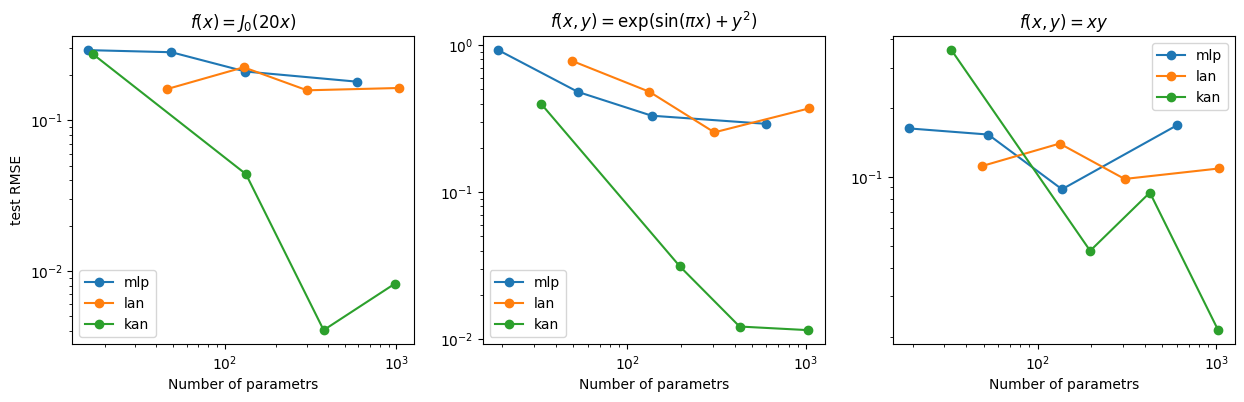

In [158]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(figsize=(15, 4), ncols=3)

axs[0].set_ylabel('test RMSE')

for ax, func_name in zip(axs.flat, func_metrics):
    model_metrics = func_metrics[func_name]

    ax.set_title('$'+func_name+'$')
    ax.set_xlabel('Number of parametrs')

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.plot(get_par(model_metrics['mlp'],'parameters'), get_par(model_metrics['mlp'], 'test_RMSE'), '-o', label = 'mlp')
    ax.plot(get_par(model_metrics['lan'],'parameters'), get_par(model_metrics['lan'], 'test_RMSE'), '-o', label = 'lan')
    ax.plot(get_par(model_metrics['kan'],'parameters'), get_par(model_metrics['kan'], 'test_RMSE'), '-o', label = 'kan')

    ax.legend()

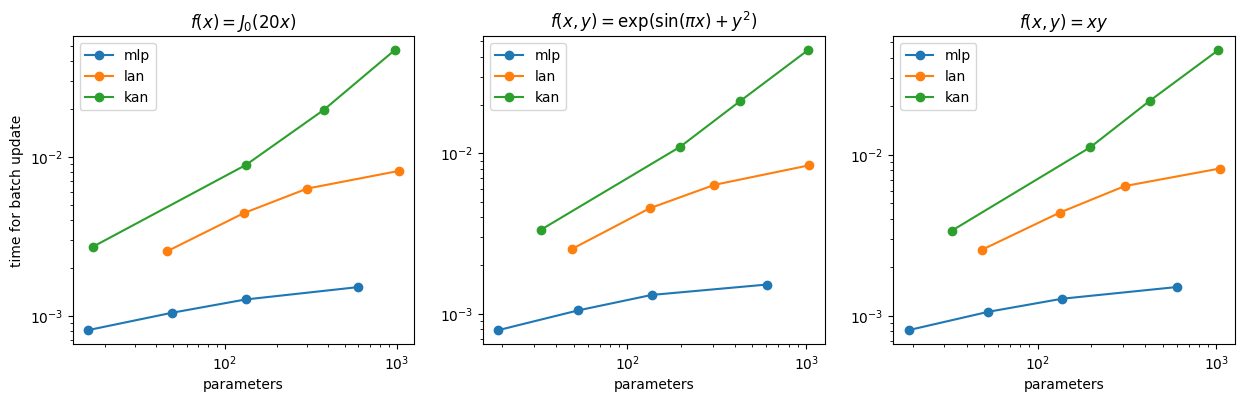

In [161]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(figsize=(15, 4), ncols=3)

axs[0].set_ylabel('time for batch update')

for ax, func_name in zip(axs.flat, func_metrics):
    model_metrics = func_metrics[func_name]

    ax.set_title('$'+func_name+'$')
    ax.set_xlabel('parameters')

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.plot(get_par(model_metrics['mlp'],'parameters'), get_par(model_metrics['mlp'], 'time'), '-o', label = 'mlp')
    ax.plot(get_par(model_metrics['lan'],'parameters'), get_par(model_metrics['lan'], 'time'), '-o', label = 'lan')
    ax.plot(get_par(model_metrics['kan'],'parameters'), get_par(model_metrics['kan'], 'time'), '-o', label = 'kan')

    ax.legend()